In [ ]:
import numpy as np
img = np.load("/data/anlab/Yunhe/mri_reconstruction_tools/output/01/images.npy")

In [ ]:
img.shape

In [ ]:
from matplotlib import pyplot as plt
i = img[0, 0, :, 30, :]


plt.imshow(abs(i), cmap='gray')

In [1]:
import os
import numpy as np
from mrboost import reconstruction as recon
from dlboost.utils.tensor_utils import complex_normalize_abs_95
from mrboost.sequence.CAPTURE_VarW_NQM_DCE_PostInj import (
    CAPTURE_VarW_NQM_DCE_PostInj_Args,
    mcnufft_reconstruct,
    preprocess_raw_data,
)
from mrboost.io_utils import get_raw_data
from mrboost.computation import normalization
import torch

In [2]:
# Load data 
RAW_DATA_PATH="/data/anlab/RawData_MR/CCIR_01168_ONC-DCE/ONC-DCE-014/meas_MID00099_FID12331_CAPTURE_FA14_5_Dyn.dat"
raw_data, shape_dict, mdh, twixobj = get_raw_data(RAW_DATA_PATH)


Software version: VD/VE (!?)

Scan  0


100%|██████████| 13.9M/13.9M [00:00<00:00, 25.9MB/s]


Scan  1


100%|██████████| 6.93G/6.93G [02:43<00:00, 45.5MB/s]


{'ch_num': 15, 'partition_num': 32, 'spoke_num': 3000, 'spoke_len': 320}


In [3]:
args = CAPTURE_VarW_NQM_DCE_PostInj_Args(
        shape_dict,
        mdh,
        twixobj,
        phase_num=5, # 10
        time_per_contrast=10, # 20
        frequency_encoding_oversampling_removed=True,
        device=torch.device("cuda:1"),
    )
data_dict_func = preprocess_raw_data(raw_data, args)

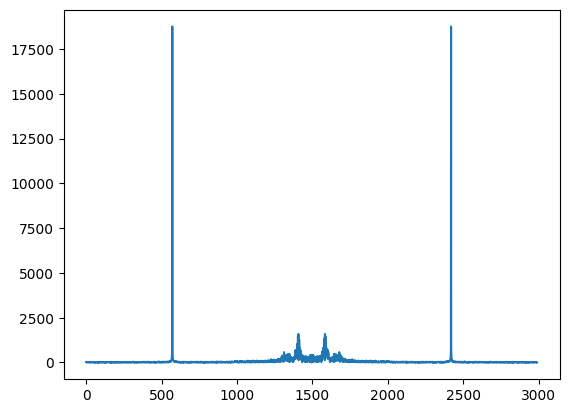

In [7]:
import matplotlib.pyplot as plt
# plot data_dict_func["respiratory_curve"]
r = data_dict_func["r"]
r = r.cpu().numpy()
plt.plot(r)

(2990,)

(0.0, 3.0)

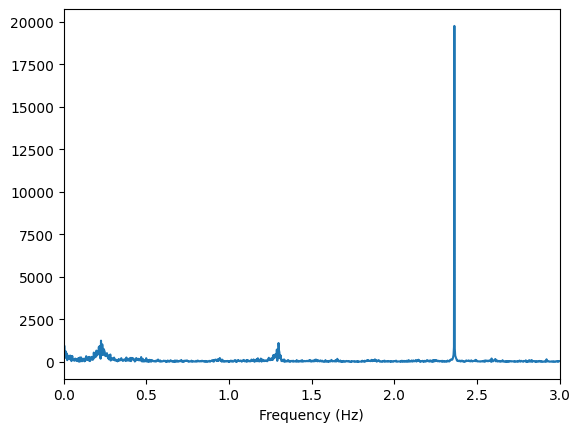

In [5]:
# plot R
from matplotlib import pyplot as plt
r = data_dict_func["r"]
r = r.cpu().numpy()
Fs = args.Fs
f = np.linspace(-Fs/2, Fs/2, r.shape[0])
plt.plot(f, r)
plt.xlabel("Frequency (Hz)")
plt.xlim([0, 3])
# Given f is the frequency of the respiratory curve, We need to zoom in the frequency range of [0, 1] Hz

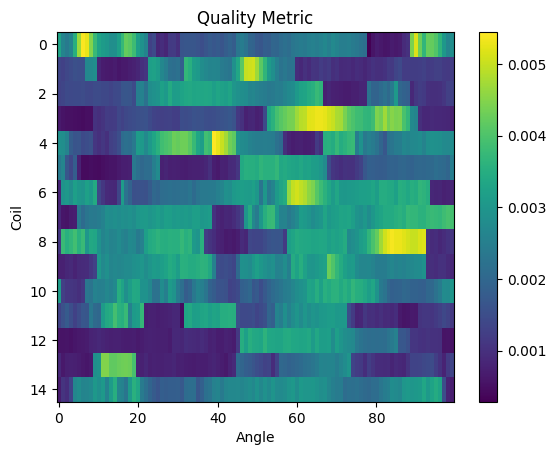

In [6]:
qm = data_dict_func['Quality_metric']


plt.imshow(qm, aspect='auto')
plt.colorbar()
plt.xlabel("Angle")
plt.ylabel("Coil")
plt.title("Quality Metric")
plt.show()


In [2]:
%cd /data/anlab/Yunhe/mri_reconstruction_tools/src/P2P_yunhe

from tasks.P2PCSE import Recon

/data/anlab/Yunhe/mri_reconstruction_tools/src/P2P_yunhe


/data/anlab/Yunhe/mri_reconstruction_tools/.venv/lib/python3.11/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [15]:
from matplotlib import pyplot as plt

c = data_dict_func["curves"].cpu().numpy().flatten()


In [68]:
# Example phase boundaries (you can adjust this if needed)
phase_boundaries = [0, 15, 30, 45, 60, 75]

# Assume idx is the index array showing where each original entry is placed in the sorted array
idx = data_dict_func["idx"]

# Step 1: Create the inverse index array
# This tells us, for each entry in the sorted array, where it came from in the original array
inverse_idx = np.argsort(idx)

# Step 2: Create an empty array to store the phase classification
phase_classification = np.zeros_like(idx)

# Helper function to assign the sorted index to a respiratory phase based on boundaries
def assign_to_phase(sorted_idx, phase_boundaries):
    """
    Assign a given index to a respiratory phase based on the phase boundaries.
    """
    for phase in range(len(phase_boundaries) - 1):
        if phase_boundaries[phase] <= sorted_idx < phase_boundaries[phase + 1]:
            return phase
    return None  # Should never reach this

# Step 3: Assign each entry in the original array to a phase
for i in range(inverse_idx.shape[0]):  # Loop over contrasts
    for j in range(inverse_idx.shape[1]):  # Loop over spokes
        # Use the inverse index (destination index in sorted array)
        sorted_idx = inverse_idx[i, j]
        
        # Assign to the phase based on the sorted index position
        phase_classification[i, j] = assign_to_phase(sorted_idx, phase_boundaries)

In [77]:
f_idx = phase_classification.flatten()

In [78]:
f_idx

array([0, 0, 0, ..., 0, 0, 0])

In [31]:
rc = c.reshape(34, 75)
sc = data_dict_func["sorted_r"]

In [44]:
sr_id = np.argsort(rc, axis=1)

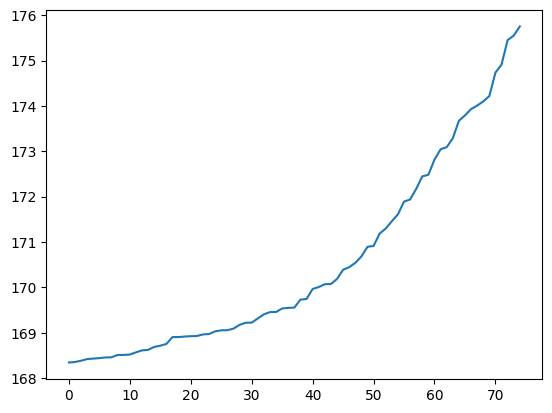

In [58]:
sr_idx = sr_id[0, :]
rc_x = rc[0, :]

plt.plot(rc_x[sr_idx])

In [67]:
sr_idx, rc_x[sr_idx]

(array([68, 69, 67,  4,  5, 66,  3, 70,  2, 65,  6,  1, 64,  0, 71,  7, 63,
        35, 36, 34, 62, 33, 32, 37,  8, 72, 31, 61, 38, 60, 30, 59, 58,  9,
        29, 57, 39, 73, 56, 28, 10, 55, 27, 40, 74, 54, 26, 11, 41, 25, 53,
        12, 42, 24, 52, 43, 13, 23, 51, 44, 14, 22, 45, 50, 46, 15, 49, 21,
        47, 48, 16, 20, 17, 19, 18]),
 array([168.34501766, 168.35564599, 168.38375403, 168.42032189,
        168.43118194, 168.44062979, 168.45567623, 168.45887648,
        168.51056351, 168.5112931 , 168.52012689, 168.56793962,
        168.61151427, 168.62340393, 168.68775475, 168.71549728,
        168.75334024, 168.90496968, 168.90535883, 168.91651278,
        168.92427732, 168.92774086, 168.96327391, 168.97210222,
        169.03030007, 169.05393055, 169.05644532, 169.09004534,
        169.17387633, 169.22028491, 169.22359167, 169.31481137,
        169.40590759, 169.45508989, 169.4582862 , 169.53523182,
        169.54851776, 169.55433497, 169.7306254 , 169.74387725,
        169.964914

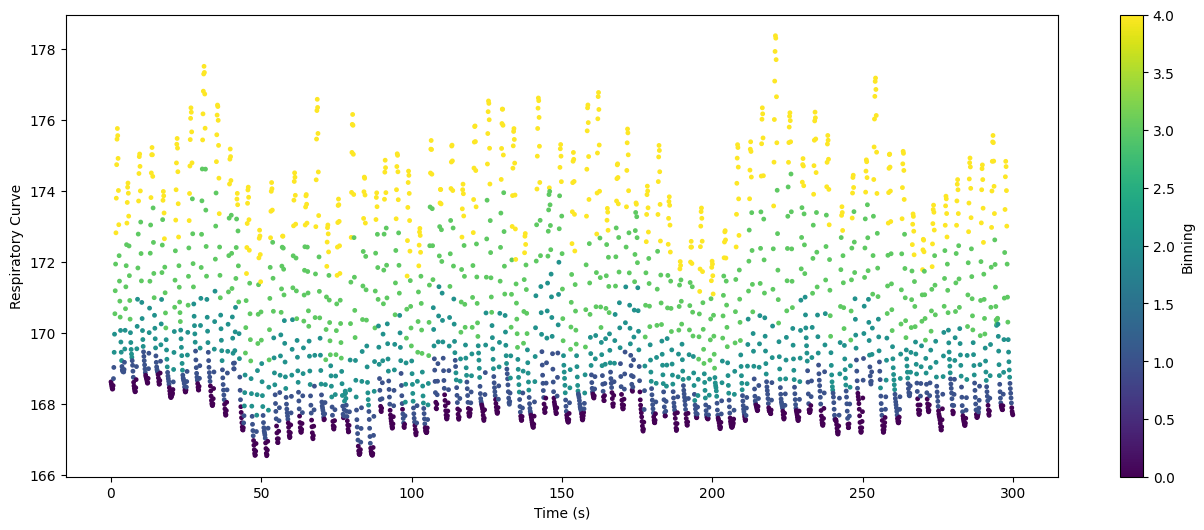

In [85]:
plt.figure(figsize=(16, 6)) 
time = np.linspace(0, 300, 2550)
scatter = plt.scatter(time, c, c=f_idx, cmap='viridis', s = 6)
cbar = plt.colorbar(scatter)
cbar.set_label('Binning')
xlabel = plt.xlabel('Time (s)')
ylable = plt.ylabel('Respiratory Curve')

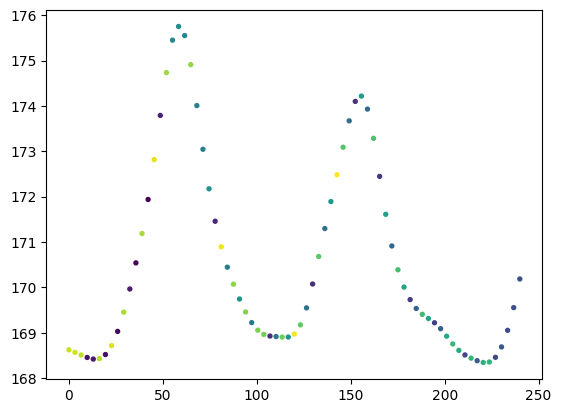

In [57]:
plt.scatter(np.linspace(0, 240, 75), rc[0, :], c=sr_id[0, :], cmap='viridis', s = 8)

In [32]:
sc.shape

torch.Size([34, 75])

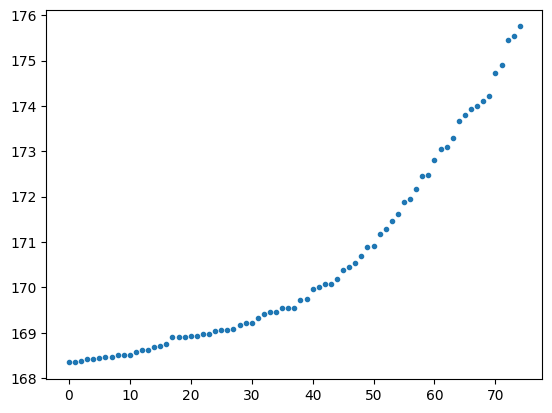

In [53]:
plt.plot(sc.flatten()[0:75], '.')

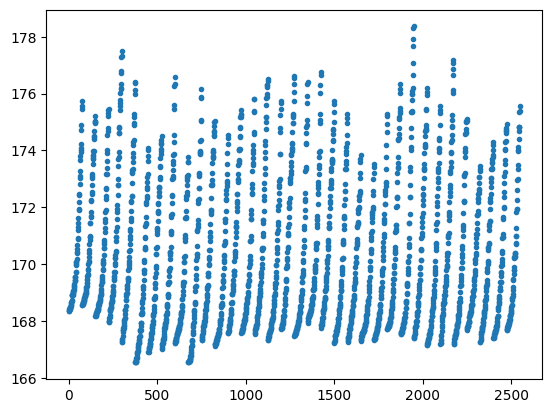

In [38]:
plt.plot(sr.flatten(), '.')

In [4]:
images, csm = mcnufft_reconstruct(data_dict_func, args)
mean, std = complex_normalize_abs_95(
        images, expand=False
    )
    
images_normed = images / std

torch.Size([30, 5, 15, 80, 15, 320])
torch.Size([30, 5, 2, 15, 320])
reconstructing contrast 1 phase 1
reconstructing contrast 1 phase 2


KeyboardInterrupt: 

In [87]:
images_normed.shape

torch.Size([34, 5, 80, 320, 320])

In [114]:
slice_data = images_normed[:, 3, 40, :, :].numpy()

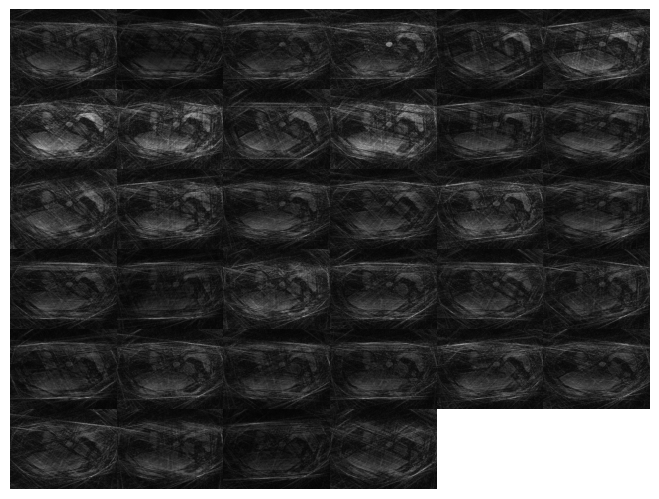

In [116]:
fig, axes = plt.subplots(6, 6)  # Create 36 subplots (6x6)

# Plot on each subplot
for i in range(34):  # You have 34 subplots to fill
    row = i // 6
    col = i % 6

    ax = axes[row, col]  # Access the appropriate subplot
    ax.imshow(abs(slice_data[i].T), cmap='gray', aspect='auto')  # Display the 2D slice
    # ax.set_title(f'Slice {i+1}')
    ax.axis('off')  # Turn off the axis for better visualization

# Remove extra subplots (36-34 = 2 empty ones)
axes[5, 4].axis('off')
axes[5, 5].axis('off')

# Adjust layout
# plt.tight_layout()
plt.subplots_adjust(left=0, right=1, top=1, bottom=0, hspace=0, wspace=0)

plt.show()